In [1]:
import deepxde as dde
import numpy as np


def gen_traindata():
    data = np.load("Lorenz.npz")
    return data["t"], data["y"]


C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)

# Most backends
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]


# Backend JAX
# def Lorenz_system(x, y, unknowns=[C1, C2, C3]):
#     C1, C2, C3 = unknowns
#     y_val, y_fn = y
#     y1, y2, y3 = y_val[:, 0:1], y_val[:, 1:2], y_val[:, 2:3]
#     dy1_x, _ = dde.grad.jacobian(y, x, i=0)
#     dy2_x, _ = dde.grad.jacobian(y, x, i=1)
#     dy3_x, _ = dde.grad.jacobian(y, x, i=2)
#     return [
#         dy1_x - C1 * (y2 - y1),
#         dy2_x - y1 * (C2 - y3) + y2,
#         dy3_x - y1 * y2 + C3 * y3,
#     ]


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.icbc.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.icbc.IC(geom, lambda X: 27, boundary, component=2)

# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

net = dde.nn.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[C1, C2, C3])
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(iterations=60000, callbacks=[variable])


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


Compiling model...
Building feed-forward neural network...
'build' took 0.082207 s



C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.623676 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [9.64e-03, 3.43e-02, 1.03e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.43e+01, 4.06e+01, 2.62e+02]    [9.64e-03, 3.43e-02, 1.03e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.43e+01, 4.06e+01, 2.62e+02]    []  
1000      [6.66e+00, 2.50e+00, 2.37e+00, 2.98e+01, 1.88e-02, 2.02e+00, 3.31e+01, 7.47e+00, 9.76e+00]    [6.66e+00, 2.50e+00, 2.37e+00, 2.98e+01, 1.88e-02, 2.02e+00, 3.31e+01, 7.47e+00, 9.76e+00]    []  
2000      [9.50e+00, 1.88e+00, 1.22e+00, 1.72e+01, 3.62e-01, 1.59e+00, 3.29e+01, 1.48e+01, 4.81e+00]    [9.50e+00, 1.88e+00, 1.22e+00, 1.72e+01, 3.62e-01, 1.59e+00, 3.29e+01, 1.48e+01, 4.81e+00]    []  
3000      [9.16e+00, 1.93e+00, 1.06e+00, 1.49e+01, 3.81e-01, 1.48e+00, 3.29e+01, 1.66e+01, 3.66e+00]    [9.16

39000     [1.37e-02, 3.12e-02, 1.04e-02, 2.56e-04, 2.36e-06, 2.87e-04, 2.08e-03, 2.85e-03, 4.74e-03]    [1.37e-02, 3.12e-02, 1.04e-02, 2.56e-04, 2.36e-06, 2.87e-04, 2.08e-03, 2.85e-03, 4.74e-03]    []  
40000     [1.13e-02, 2.68e-02, 1.20e-02, 2.24e-05, 6.54e-06, 1.80e-05, 1.85e-03, 2.40e-03, 3.97e-03]    [1.13e-02, 2.68e-02, 1.20e-02, 2.24e-05, 6.54e-06, 1.80e-05, 1.85e-03, 2.40e-03, 3.97e-03]    []  
41000     [2.28e-02, 2.59e-02, 5.69e-02, 9.89e-06, 7.78e-05, 6.73e-07, 1.63e-03, 2.70e-03, 3.35e-03]    [2.28e-02, 2.59e-02, 5.69e-02, 9.89e-06, 7.78e-05, 6.73e-07, 1.63e-03, 2.70e-03, 3.35e-03]    []  
42000     [1.23e-02, 2.10e-02, 1.70e-02, 8.29e-05, 7.52e-06, 6.68e-05, 1.25e-03, 1.96e-03, 2.83e-03]    [1.23e-02, 2.10e-02, 1.70e-02, 8.29e-05, 7.52e-06, 6.68e-05, 1.25e-03, 1.96e-03, 2.83e-03]    []  
43000     [1.67e-02, 1.94e-02, 3.37e-02, 2.51e-05, 3.63e-05, 7.33e-06, 1.11e-03, 1.87e-03, 2.38e-03]    [1.67e-02, 1.94e-02, 3.37e-02, 2.51e-05, 3.63e-05, 7.33e-06, 1.11e-03, 1.87e-03, 2.3

Saving loss history to C:\Users\kozak\Desktop\國網中心\Python_Training\Deepxde\Deepxde_Lorenz_system\loss.dat ...
Saving training data to C:\Users\kozak\Desktop\國網中心\Python_Training\Deepxde\Deepxde_Lorenz_system\train.dat ...
Saving test data to C:\Users\kozak\Desktop\國網中心\Python_Training\Deepxde\Deepxde_Lorenz_system\test.dat ...


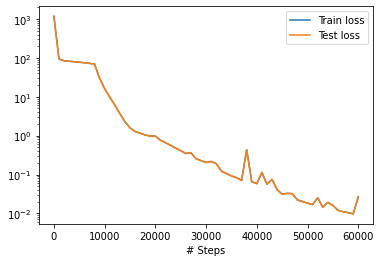

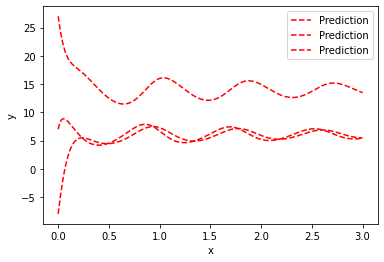

In [2]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

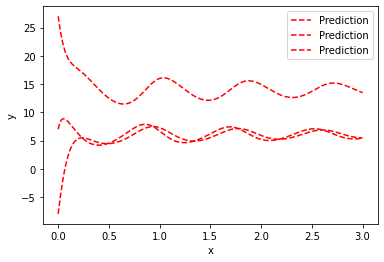

In [15]:
import matplotlib.pyplot as plt
dde.utils.external.plot_best_state(train_state)
plt.show()

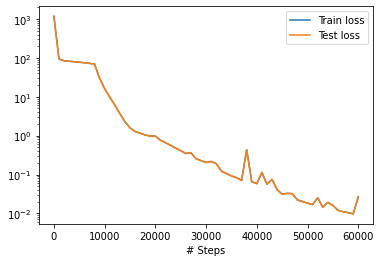

In [16]:
dde.utils.external.plot_loss_history(losshistory)